In [107]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [108]:
print(tf.__version__)

2.10.0


In [109]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [111]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [112]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [113]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .20)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [114]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [115]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [116]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     15
Name: binding, dtype: int64
0    217
1     63
Name: binding, dtype: int64


In [117]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(table.sequence).reshape(-1,1),table.binding)
# sampler = RandomOverSampler(sampling_strategy=.65)
# x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [118]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    722
1    722
Name: binding, dtype: int64
0    217
1     63
Name: binding, dtype: int64


In [119]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding,1, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [120]:
print(training_split.shape)
print(test_split.shape)

(1444, 84482)
(280, 84482)


In [121]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
# print(train_result.shape)
# print(test_result.shape)


In [122]:
# from sklearn.decomposition import KernelPCA
# pca = KernelPCA()
# training_split = pca.fit_transform(training_split)
# test_split = pca.transform(test_split)

In [123]:
training_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [128]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        current_test_precision = logs.get('val_precision')
        current_test_recall= logs.get('val_recall')
        if current_train_precision==0 or current_train_recall==0 or current_test_precision==0 or current_test_recall==0:
            print("** Waring: precision reacall zero avoid exception **")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        self.f1_test = (2*current_test_precision*current_test_recall) / (current_test_precision+current_test_recall)
        if abs(self.f1_train-self.f1_test) < .01 and 1>self.f1_test>.98:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('Stoping on set citeria')
            print('f1 training: ', self.f1_train)
            print('f1 testing: ' , self.f1_test)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("Early stopping")


In [129]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    tf.keras.layers.Dense(26,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
    tf.keras.layers.Dense(26,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [130]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

In [131]:
num_epochs = 120
history = model.fit(training_split, train_result,
                    epochs=num_epochs,
                    batch_size=70,
                    validation_data=(test_split, test_result),
                    callbacks=[EarlyStoppingMonitor()])
# ,callbacks=[tf.keras.callbacks.EarlyStopping()]

Epoch 1/120


2022-10-08 14:51:10.144620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 40.8867 - tp: 478.0000 - fp: 63.0000 - tn: 659.0000 - fn: 244.0000 - precision: 0.8835 - recall: 0.6620

2022-10-08 14:51:11.710191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 76ms/step - loss: 40.8867 - tp: 478.0000 - fp: 63.0000 - tn: 659.0000 - fn: 244.0000 - precision: 0.8835 - recall: 0.6620 - val_loss: 15.5024 - val_tp: 46.0000 - val_fp: 1.0000 - val_tn: 216.0000 - val_fn: 17.0000 - val_precision: 0.9787 - val_recall: 0.7302
Epoch 2/120
21/21 [==============================] - 1s 52ms/step - loss: 10.0221 - tp: 539.0000 - fp: 12.0000 - tn: 710.0000 - fn: 183.0000 - precision: 0.9782 - recall: 0.7465 - val_loss: 6.9910 - val_tp: 42.0000 - val_fp: 4.0000 - val_tn: 213.0000 - val_fn: 21.0000 - val_precision: 0.9130 - val_recall: 0.6667
Epoch 3/120
21/21 [==============================] - 1s 49ms/step - loss: 6.1991 - tp: 468.0000 - fp: 15.0000 - tn: 707.0000 - fn: 254.0000 - precision: 0.9689 - recall: 0.6482 - val_loss: 5.6573 - val_tp: 48.0000 - val_fp: 6.0000 - val_tn: 211.0000 - val_fn: 15.0000 - val_precision: 0.8889 - val_recall: 0.7619
Epoch 4/120
21/21 [==============================] - 1s 48ms/step - lo

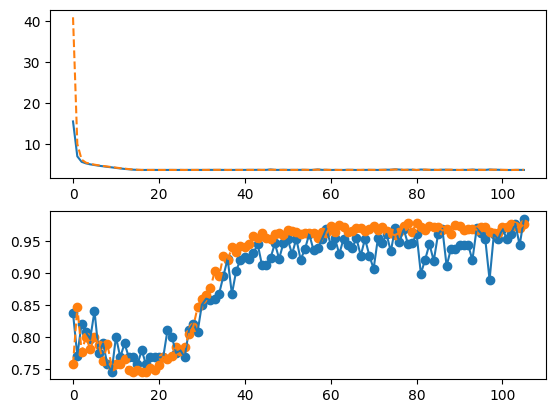

In [132]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.scatter(history.epoch, k)
ax2.scatter(history.epoch, j)
ax2.plot(history.epoch, k,'-')
ax2.plot(history.epoch, j,'--')
# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

In [133]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [134]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()
# unlabeled_test_sequence = pca.transform(unlabeled_test_sequence)

In [135]:
unlabeled_test_sequence.shape

(350, 84482)

In [136]:
y = model.predict(unlabeled_test_sequence)

 5/11 [============>.................] - ETA: 0s

2022-10-08 14:54:09.952530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 29ms/step


In [137]:
y

array([[0.39539772],
       [0.21788993],
       [0.28535858],
       [0.3072105 ],
       [0.23216017],
       [0.21788982],
       [0.22543976],
       [0.25251827],
       [0.32215527],
       [0.5751451 ],
       [0.27413505],
       [0.26076624],
       [0.25401515],
       [0.30343357],
       [0.25170746],
       [0.29817453],
       [0.21789056],
       [0.28926146],
       [0.26155996],
       [0.22795089],
       [0.2597257 ],
       [0.27783826],
       [0.23627959],
       [0.28999904],
       [0.307102  ],
       [0.70568424],
       [0.30187583],
       [0.23927084],
       [0.32860142],
       [0.21789029],
       [0.25407046],
       [0.26422948],
       [0.2580394 ],
       [0.2310973 ],
       [0.27743194],
       [0.2655604 ],
       [0.23816879],
       [0.2570535 ],
       [0.3549741 ],
       [0.29844984],
       [0.25111985],
       [0.23244557],
       [0.2213889 ],
       [0.26417592],
       [0.27401814],
       [0.22289294],
       [0.28877226],
       [0.342

In [138]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [139]:
len(z)

350

In [140]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()